In [78]:
import torch
import torch.nn as nn

#Model

In [79]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(2,64),
        nn.Tanh(),
        nn.Linear(64,64),
        nn.Tanh(),
        nn.Linear(64,2)
    )

  def forward(self,x):
    return self.net(x)

#Training

In [80]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

In [81]:
#-------------
# Load data
#-------------

data = np.load("pendulum_no_control_dataset.npz")
split = np.load("splits_no_control.npz")

X = np.hstack(data["X"])
X = data["X"].reshape(10000, 2)
Y = data["Y"]
Y = data["Y"].reshape(10000, 2)
print(X.shape)

#---------------
# Normalization
#---------------

X_mean = X.mean()
X_std  = X.std()

Y_mean = Y.mean()
Y_std  = Y.std()

X = (X - X_mean) / X_std
Y = (Y - Y_mean) / Y_std


X_train = X[split["train_idx"]]
Y_train = Y[split["train_idx"]]

X_test = X[split["test_idx"]]
Y_test = Y[split["test_idx"]]

#-------------------
# Convert to tensor
#-------------------

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#---------
#  Model
#---------

model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

#----------------
# Training loop
#----------------

n_epochs = 500

for epoch in range(n_epochs):
  model.train()
  train_loss = 0.0

  for X_batch, Y_batch in train_loader:
    Y_pred = model(X_batch)
    loss = loss_fn(Y_pred, Y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)

  model.eval()

  with torch.no_grad(): # Compute loss on test dataset without grad
    test_loss = 0.0
    for X_batch, Y_batch in test_loader:
      Y_pred = model(X_batch)
      loss = loss_fn(Y_pred, Y_batch)

      test_loss += loss.item()

    test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#-------------
# Save model
#-------------

torch.save(model.state_dict(), "mlp.pth")

(10000, 2)
Epoch 1/500, Train Loss: 0.6884, Test Loss: 1.3111
Epoch 2/500, Train Loss: 0.6661, Test Loss: 1.3084
Epoch 3/500, Train Loss: 0.6595, Test Loss: 1.2784
Epoch 4/500, Train Loss: 0.6576, Test Loss: 1.2810
Epoch 5/500, Train Loss: 0.6528, Test Loss: 1.2814
Epoch 6/500, Train Loss: 0.6415, Test Loss: 1.2633
Epoch 7/500, Train Loss: 0.6212, Test Loss: 1.2155
Epoch 8/500, Train Loss: 0.5807, Test Loss: 1.1291
Epoch 9/500, Train Loss: 0.5224, Test Loss: 0.9957
Epoch 10/500, Train Loss: 0.4714, Test Loss: 0.8906
Epoch 11/500, Train Loss: 0.4313, Test Loss: 0.7754
Epoch 12/500, Train Loss: 0.3862, Test Loss: 0.6745
Epoch 13/500, Train Loss: 0.3630, Test Loss: 0.5985
Epoch 14/500, Train Loss: 0.3382, Test Loss: 0.5415
Epoch 15/500, Train Loss: 0.3226, Test Loss: 0.4642
Epoch 16/500, Train Loss: 0.3017, Test Loss: 0.4034
Epoch 17/500, Train Loss: 0.2856, Test Loss: 0.3469
Epoch 18/500, Train Loss: 0.2657, Test Loss: 0.2728
Epoch 19/500, Train Loss: 0.2415, Test Loss: 0.2224
Epoch 20/5

#Rollout with RK4

In [82]:
import matplotlib.pyplot as plt

In [83]:
def pendulum_dynamics(x, u, params):  # Compute the function f(x,t) such that theta'' = f(x,t)
  theta, omega = x
  m, l, g = params["m"], params["l"], params["g"]
  u = float(u)

  d_theta = omega
  d_omega = (g/l) * np.sin(theta) + u/(m * l**2)

  return np.array([d_theta, d_omega])

def rk4_step_torch(f, x, dt):
    k1 = f(x)
    k2 = f(x + 0.5 * dt * k1)
    k3 = f(x + 0.5 * dt * k2)
    k4 = f(x + dt * k3)
    return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)


def rk4_step(f, x, u, dt, params):  # Compute the position after a short time dt based on the pervious position using rk4 method
  k1 = f(x, u, params)
  k2 = f(x + 0.5 * dt * k1, u, params)
  k3 = f(x + 0.5 * dt * k2, u, params)
  k4 = f(x + dt * k3, u, params)

  return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def trajectory_simulation(x0, u_control, dt, T, params):
  N = int(T/dt)
  x = np.zeros((N+1, 2))
  x[0] = x0
  for t in range(N):
    u = u_control(t * dt, x[t])
    x[t+1] = rk4_step(pendulum_dynamics, x[t], u, dt, params)
  return x

def trajectory_simulation_mlp(x0, dt, T):
    N = int(T / dt)
    x = torch.zeros((N+1, 2))
    x[0] = torch.tensor(x0, dtype=torch.float32)

    for t in range(N):
        x[t+1] = rk4_step_torch(f_hat, x[t], dt)

    return x.numpy()


def zero_control(t,x):
  return 0

def f_hat(x):
    #x : torch tensor shape (2,)
    #returns dx/dt in physical units

    x_n = (x - X_mean) / X_std

    with torch.no_grad():
        y_n = model(x_n)

    y = y_n * Y_std + Y_mean
    return y



#Results

(1001, 2)
(1001, 2)
(1001,)


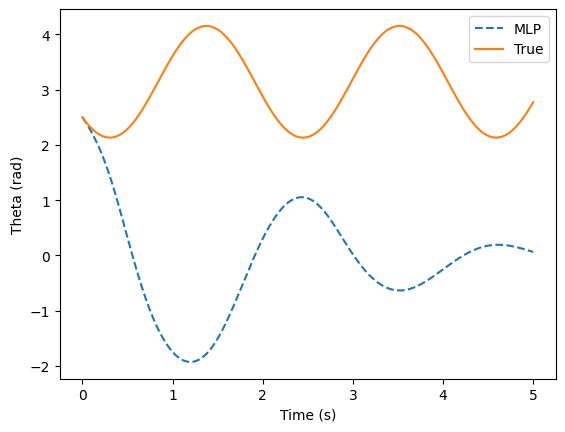

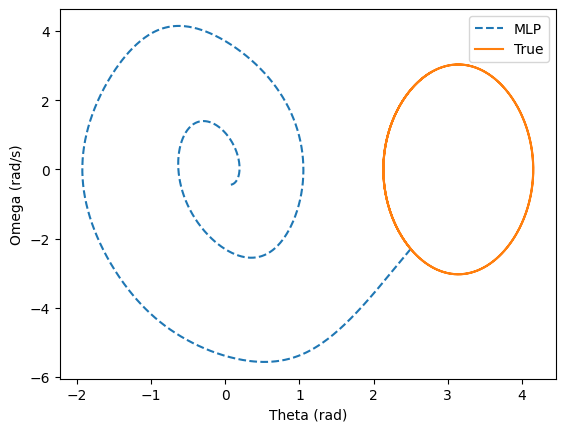

In [88]:
#--------------
# Parameters
#--------------

params = {
    "g": 9.81,   # gravity (m/s^2)
    "l": 1.0,    # lenght (m)
    "m": 1.0     # mass (kg)
}

x0 = [2.5,-2.3]
mlp_trajectory = []
true_trajectory = []
T = 5 # 5s
dt = 0.005 # 1000 step

#--------------
# Trajectories
#--------------

mlp_trajectory = trajectory_simulation_mlp(x0, dt, T)

true_trajectory = trajectory_simulation(x0, zero_control, T=5.0, dt=0.005, params=params)

#-------
# Plot
#-------

t = np.arange(start = 0, stop = 5.005, step = dt)

print(mlp_trajectory.shape)
print(true_trajectory.shape)
print(t.shape)

plt.plot(t, np.array(mlp_trajectory)[:,0], "--")
plt.plot(t, np.array(true_trajectory)[:,0])
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.legend(["MLP", "True"])
plt.show()

plt.figure()
plt.plot(np.array(mlp_trajectory)[:,0], np.array(mlp_trajectory)[:,1], "--")
plt.plot(np.array(true_trajectory)[:,0], np.array(true_trajectory)[:,1])
plt.legend(["MLP", "True"])
plt.xlabel("Theta (rad)")
plt.ylabel("Omega (rad/s)")
plt.show()


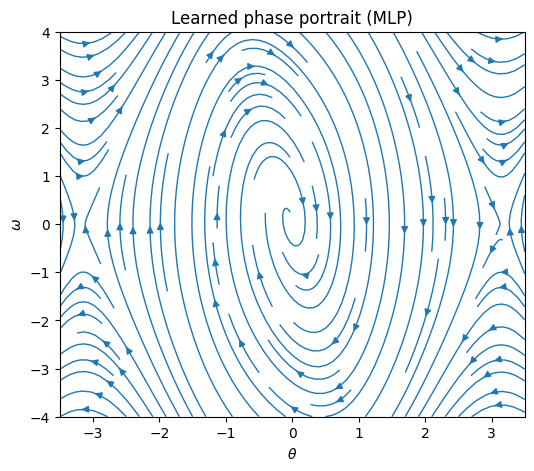

In [93]:
theta = np.linspace(-3.5, 3.5, 50)
omega = np.linspace(-4, 4, 50)

TH, OM = np.meshgrid(theta, omega)  # IMPORTANT

DX = np.zeros_like(TH)
DY = np.zeros_like(OM)

for i in range(TH.shape[0]):
    for j in range(TH.shape[1]):
        x = torch.tensor([TH[i, j], OM[i, j]], dtype=torch.float32)
        dx = f_hat(x)
        DX[i, j] = dx[0].item()
        DY[i, j] = dx[1].item()

plt.figure(figsize=(6,5))
plt.streamplot(
    TH, OM, DX, DY,
    density=1.2,
    linewidth=1
)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\omega$")
plt.title("Learned phase portrait (MLP)")
plt.show()


